# Analyzing NYC High School Data
We will combine several dataset from the city of New York to look at the SAT results of the various schools in the city. We will look at connections between survey responses, AP test results and demographics to look for correlations with the schools SAT score.

## Sat
The Scholastic Aptitude Test (SAT) is test that seniors in high school in the U.S. take every year. The max score is `2400` split into three sections that are each worth a maximum of `800` points. One indicator of a high-quality school is a good average SAT score.

## Dataframe
We will be combining several datasets into a clean dataframe for this project:
- [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City.
- [School attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt) - Attendance information for each school in New York City.
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school.
- [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school.
- [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) - The percentage of students who graduated and other outcome information.
- [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) - Demographic information for each school.
- [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) - Surveys of parents, teachers, and students at each school.

All the datasets are official releases by the city of New York.

## 1.0 Reading, cleaning and combining datasets

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from IPython.display import display
import pandas as pd

pd.set_option('display.min_rows', 20)

#Reading in all the csv files and storing them all in a dictionary
csv_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
    ]

data = {}

for csv in csv_files:
    x = pd.read_csv("{0}".format(csv))
    data[csv.replace(".csv", "")] = x


### 1.1 Adding Surveys
Reading in the surveys mentioned above as `School survey`. The surveys contain various ratings of the schools by parents, teachers and students. A full data dictionary for the surveys can be found at the link above.

In [28]:
#Reading in the surveys that are stored in tab delimited txt files with windows-1252 encoding
all_survey = pd.read_csv("survey_all.txt", delimiter='\t', encoding='windows-1252')
d75_survey = pd.read_csv("survey_d75.txt", delimiter='\t', encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey.rename(columns=({'dbn': 'DBN'}), inplace=True)

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

### 1.2 DBN columns

Preparing the `DBN` columns in the datasets so that the datasets can then be combined on this column.

In [29]:
data['hs_directory'].rename(columns=({'dbn': 'DBN'}), inplace=True)

#function to add a leading zero to csd numbers that lack one.
def padding(csd):
    string = str(csd)
    if len(string) > 1:
        return string
    else:
        return '0' + string

#Replacing csd number with the padded one and adding the school code to it to form a DBN number,
data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(padding)
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']


## 1.3 Change columns to numeric type

In [30]:
columns = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in columns:
    data['sat_results'][c] = pd.to_numeric(data['sat_results'][c], errors='coerce')

#Adding together the various SAT scores to create a total score for each school.
data['sat_results']['sat_score'] = data['sat_results'][columns[0]] + data['sat_results'][columns[1]] + data['sat_results'][columns[2]]

#Functions to extract the longitude & latitude from the 'Location 1' column in 'hs_directory' dataset.
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## 1.4 Filtering datasets

In [31]:
#Selecting only part of the `class_size` dataset
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

#Group rows with the same DBN number together and use the mean class sizes as the new values
class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

#Change the `demographics` dataset to only include the 2011-2012 schoolyear
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## 1.5 Convert AP scores to numeric type

In [32]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## 1.6 Combining the datasets

In [33]:
#Combining all the datasets on the 'DBN' column
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

#Filling in values that are missing after the merges with mean values where possible and with 0's otherwise
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

C:\Users\Mats\AppData\Local\Temp/ipykernel_3508/2139141810.py:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  combined = combined.fillna(combined.mean())


## 1.7 Add a school district column to the combined dataset

In [34]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# 2.0 Correlation between `school survey` and SAT scores

In [35]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
                                          ...   
grade_span_max                               NaN
expgrade_span_max                            NaN
zip                                    -0.063977
total_students                          0.407827
number_programs                         0.117012
priority08                                   NaN
priority09                                   NaN
priority10                                   NaN
lat                                    -0.121029
lon                 

In [36]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

We will look for correlations between the fields in `combined` that was taken from the `school survey` dataset and the SAT score column. The correlations will be plotted as barplot. 

In [37]:
#The relevant fields are stored in the `survey_fields` variable
survey_corr = correlations[survey_fields]
print(survey_corr)

rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_11      0.036906
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
Name: sat_score, dtype: float64


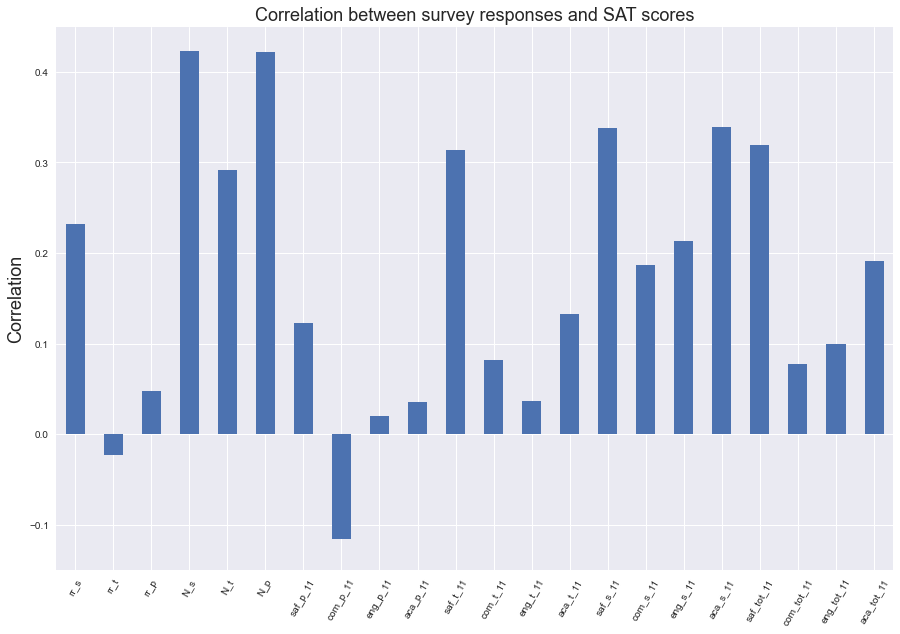

In [38]:
plt.style.use('seaborn')
fig,ax = plt.subplots(figsize=(15,10))
survey_corr.plot(kind = 'bar', y = 'sat_score', rot = 60, ax = ax)
ax.set_title('Correlation between survey responses and SAT scores', fontsize=18)
ax.set_ylabel('Correlation', fontsize=18)
ax.set_ylim([-0.15, 0.45])
ax.legend().set_visible(False)

plt.show()

The `N_s`, `N_t` and `N_p` columns are the number of student, teacher and parent respondents on the surveys.
The strongest correlations in the dataset are found for `N_s` and `N_p`. Meaning the average SAT score is higher for schools where the number of students and parents that responded to surveys are higher. Indicating that student and parent engagement is an important factor in academic achievement. The correlation is notably weaker when it comes to the number of teachers who responded to the surveys.

The only other columns to make it above `0.3` correlation was: 
- `saf_t_11` - School safety rating given by teachers
- `saf_s_11` - School safety rating given by students
- `aca_s_11` - Academic expectations score given by students
- `saf_tot_11` - Total safety rating score from all respondents

This shows that the impression & expectation of a safe environment has a modest effect on academic achievement. The students expectations for academic achievements also affects the actual academic scores obtained. Along this line, the students self-rated engagement (`eng_s_11`) also have a small correlation with SAT scores but less than expectations of achievement. The expectations & engagement of parents and teachers have only a small correlation with actual achievements.

There is a small, negative correlation between the communication score as rated by parents (`com_p_11`) and SAT scores. Indicating that poor communication from the school is slightly detrimental to student achievement.

## 2.1 Correlation between SAT scores and school safety rating
Given the correlation between school safety and SAT scores we will investigate the safety ratings of the schools closer.

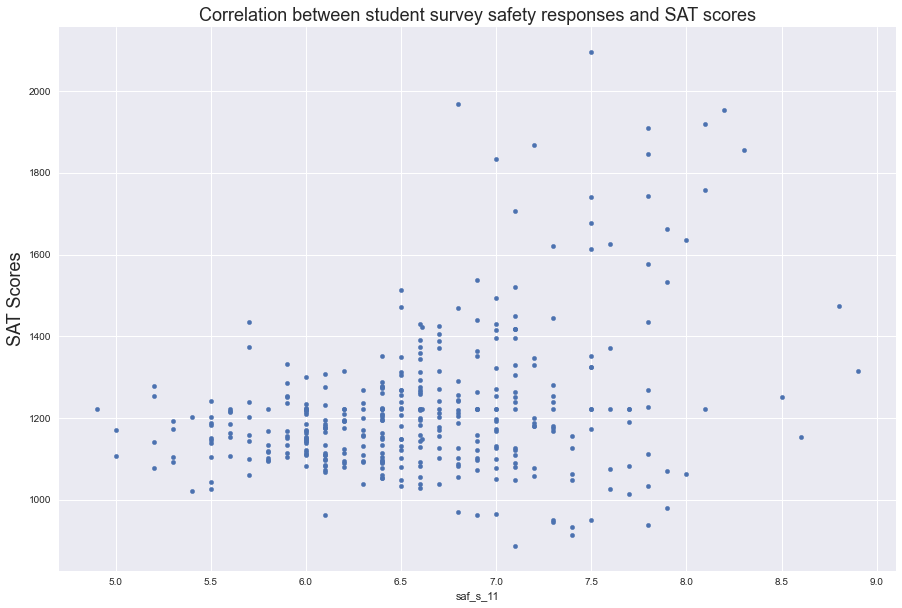

In [39]:
fig1,ax1 = plt.subplots(figsize=(15,10))
combined.plot(kind = 'scatter',x = 'saf_s_11', y = 'sat_score', ax = ax1)
ax1.set_title('Correlation between student survey safety responses and SAT scores', fontsize=18)
ax1.set_ylabel('SAT Scores', fontsize=18)

plt.show()

The scatterplot shows a connection between SAT scores and safety rating. In particular, almost all the school that had an average SAT score of over `1600` had a safety rating of over `7.0`. That being said, many schools with a high safety rating had a low average SAT score. This indicated that safety rating plays and important role in SAT scores but is not the only critical factor. 

## 2.2 Safety rating according to boroughs

Next, we will group the data by borough and calculate the average safety score for each.

In [40]:
#Extract the third character in `DBN` column which contains the letter representing the borough.
combined['borough'] = combined['DBN'].apply(lambda char: char[2])
combined['borough'].replace({'K': 'Brooklyn', 'R': 'Staten Island', 'X': 'Bronx', 'Q': 'Queens', 'M': 'Manhatten'}, inplace=True)

#Group together rows belonging to the same borough and calculate the means
borough_safety = combined.groupby('borough').agg(np.mean)

borough_safety['saf_s_11'].sort_values(ascending=False)

borough
Manhatten        6.831370
Queens           6.721875
Bronx            6.606577
Staten Island    6.530000
Brooklyn         6.370755
Name: saf_s_11, dtype: float64

Above we see the average `saf_s_11` scores for the various boroughs. There is a relatively small difference between the top and lowest scorers.

## 2.3 SAT scores according to race

We will use the `white_per`, `asian_per`, `black_per` and `hispanic_per` columns to investigate the racial differences in SAT performance.

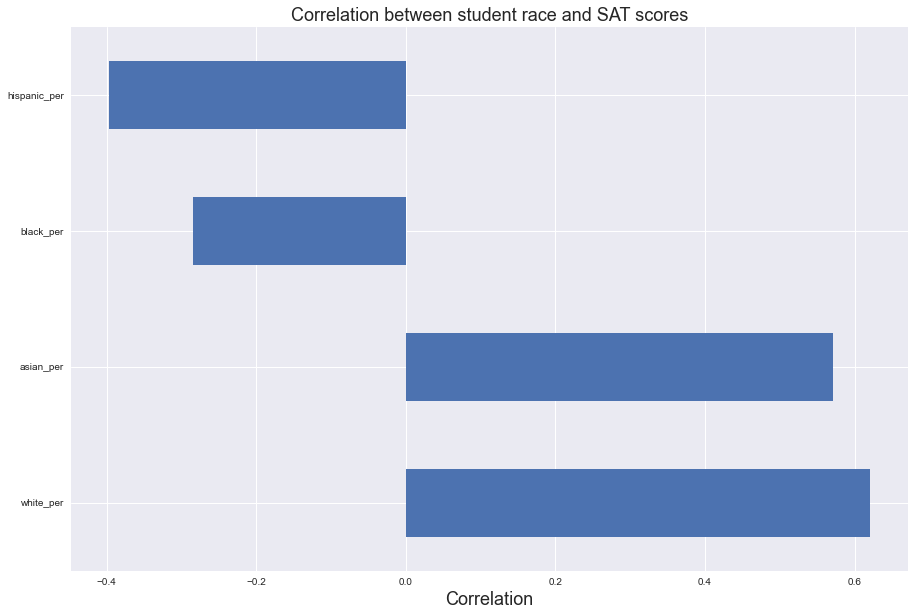

In [41]:
races = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

fig,ax = plt.subplots(figsize=(15,10))
correlations[races].plot(kind = 'barh', y = 'sat_score', ax = ax)
ax.set_title('Correlation between student race and SAT scores', fontsize=18)
ax.set_xlabel('Correlation', fontsize=18)

plt.show()

Blacks and hispanics have a negative correlation with average SAT scores, while whites and asians have a positive correlation.

### 2.3.1 Examining correlation between hispanics and SAT score

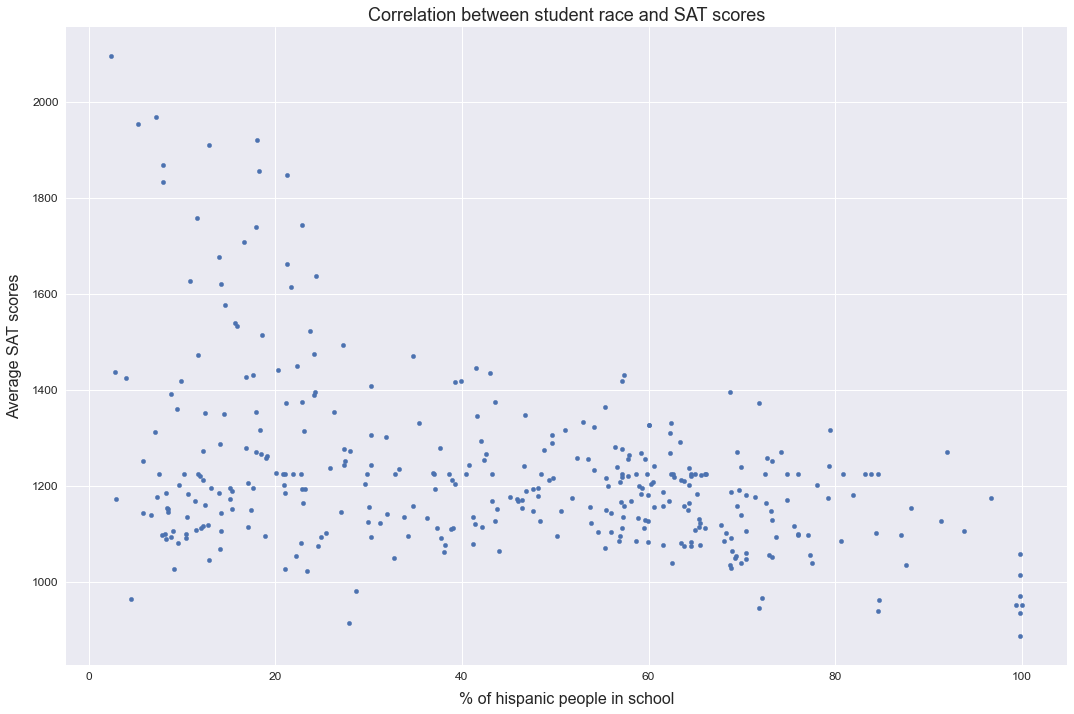

In [42]:
#Creating a scatter plot showing percentage of hispanic students vs. average SAT scores
fig,ax = plt.subplots(figsize=(15,10))
combined.plot(kind = 'scatter',x = 'hispanic_per', y = 'sat_score', ax = ax)
ax.set_title('Correlation between student race and SAT scores', fontsize=18)
ax.set_xlabel('% of hispanic people in school', fontsize=16, labelpad=10)
ax.set_ylabel('Average SAT scores', fontsize=16, labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout(pad=1)
plt.show()

There seems to be a modest correlation between the average SAT scores for the school and the percentage of hispanic students who attends it. The number of schools with an average SAT score higher than ~`1400` almost disappear when the percentage of hispanic students become greater than ~`30`. 

## 2.4 SAT scores according to gender
We will examine the correlation between gender and average SAT score for the schools.

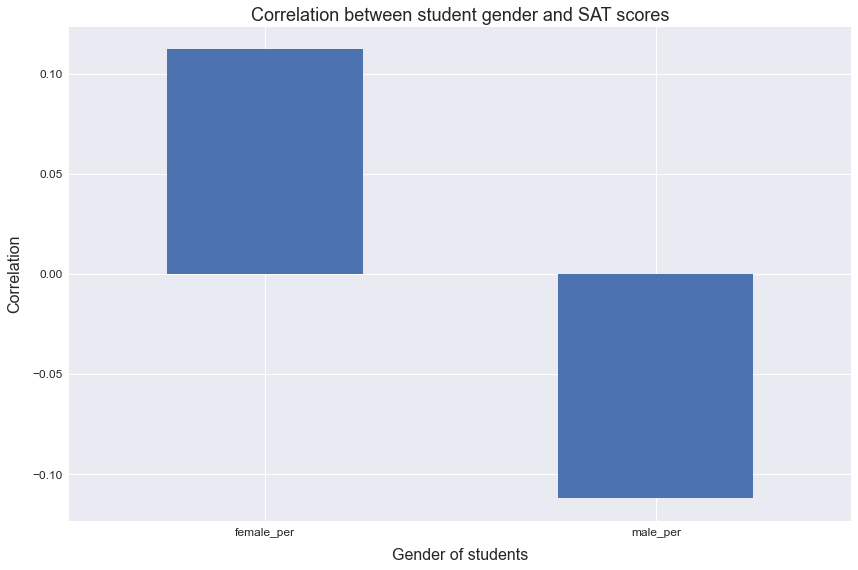

In [43]:
gender = ['female_per', 'male_per']

fig,ax = plt.subplots(figsize=(12,8))
correlations[gender].plot(kind = 'bar', y = 'sat_score', ax = ax, rot = 0)
ax.set_title('Correlation between student gender and SAT scores', fontsize=18)
ax.set_xlabel('Gender of students', fontsize=16, labelpad=10)
ax.set_ylabel('Correlation', fontsize=16, labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout(pad=1)
plt.show()

There is a slight positive correlation between female students and SAT scores and a slightly negative one for male students. Let's look at the SAT scores of schools based on the percentage of female students.

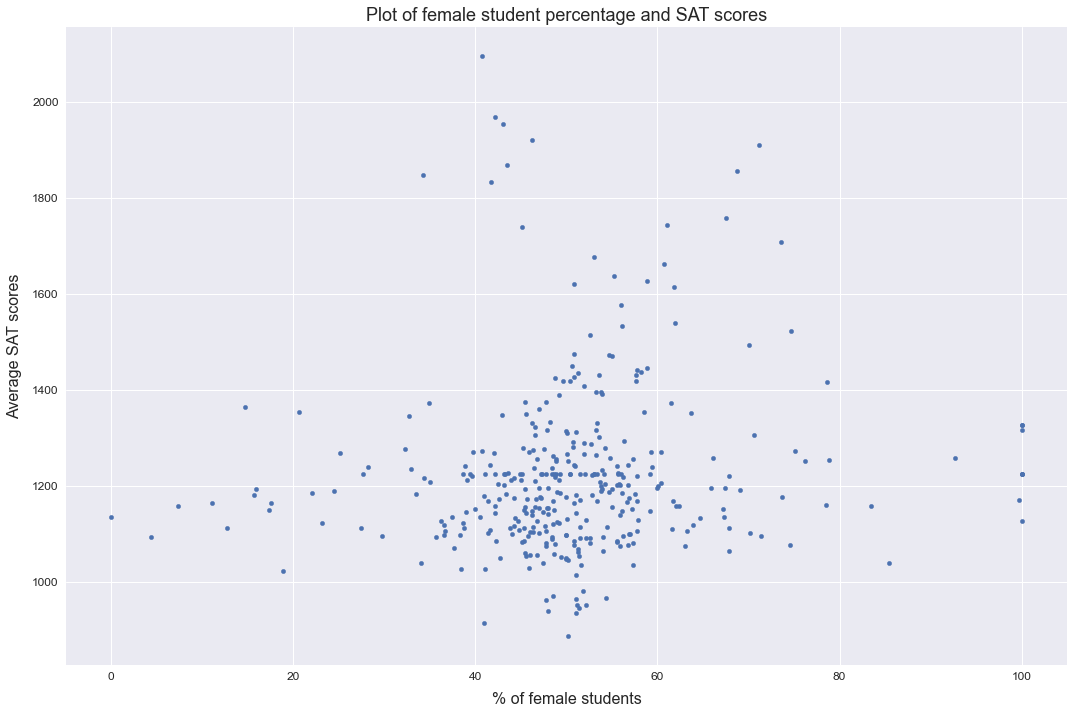

In [44]:
#Creating a scatter plot showing percentage of female students vs. average SAT scores
fig,ax = plt.subplots(figsize=(15,10))
combined.plot(kind = 'scatter',x = 'female_per', y = 'sat_score', ax = ax)
ax.set_title('Plot of female student percentage and SAT scores', fontsize=18)
ax.set_xlabel('% of female students', fontsize=16, labelpad=10)
ax.set_ylabel('Average SAT scores', fontsize=16, labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout(pad=1)
plt.show()

The scatterplot shows a high concentration around `50%` as expected since most schools are more or less evenly divided on gender.
We can see that there are no schools with a female student percentage of less than `50%` that has a SAT score over `1400`, which suggests that male students do poorer on the SAT overall. This is the expected result based on the correlation bar plot above.
There is also no schools with over `80%` female students that have a SAT score above `1400`, which may mean that all-girls schools do less well on average. 

## 2.5 Relationship between average SAT score and AP scores
The Advanced Placement (AP) exams let high school students in the U.S. earn college credit. Since the AP exams are more advanced than the SAT we would expect schools with a higher AP score to also have a higher SAT score.

In [45]:
#Calculating the percentage of students in each school that took an AP exam
combined['ap_per'] = (combined['AP Test Takers '] / combined['total_enrollment']) * 100

combined['ap_per'].head()

0    30.575556
1     9.898477
2     3.177258
3    35.157724
4    15.809051
Name: ap_per, dtype: float64

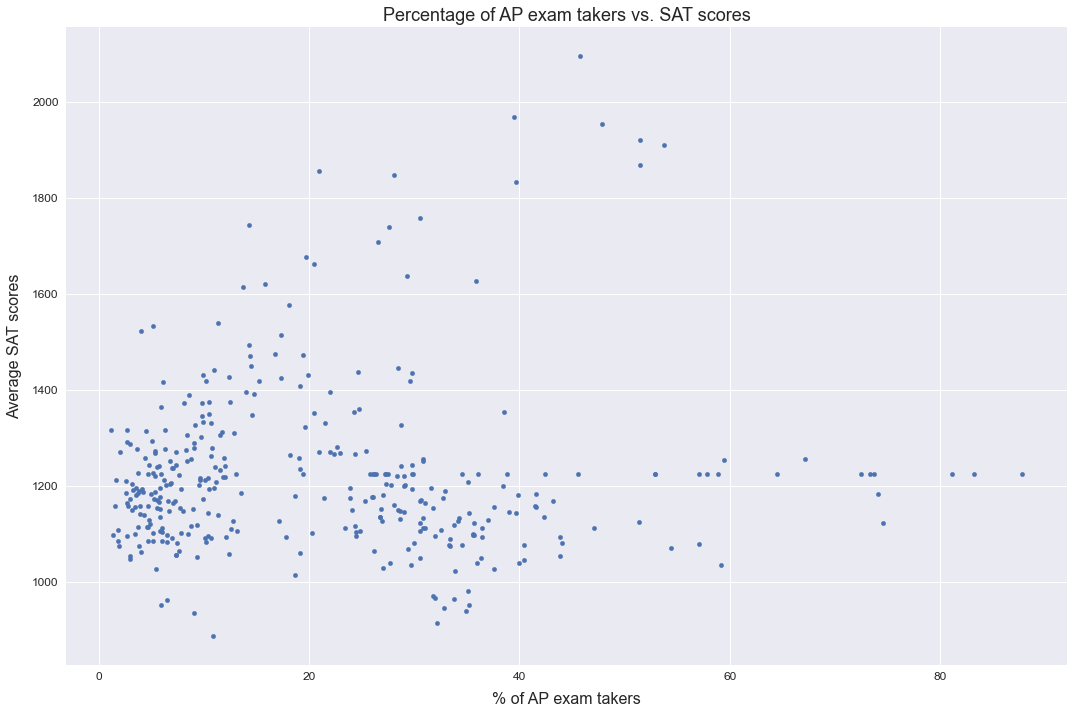

In [46]:
#Creating a scatter plot showing percentage of AP exam takers vs. average SAT scores
fig,ax = plt.subplots(figsize=(15,10))
combined.plot(kind = 'scatter', x = 'ap_per', y = 'sat_score', ax = ax)
ax.set_title('Percentage of AP exam takers vs. SAT scores', fontsize=18)
ax.set_xlabel('% of AP exam takers', fontsize=16, labelpad=10)
ax.set_ylabel('Average SAT scores', fontsize=16, labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout(pad=1)
plt.show()

# Conclusions
- Gender has a small correlation with higher SAT scores. The correlation increases as the percentage of female students increases and vice versa for males.
- Student and, to a lesser extent, parent involvement in education has a positive correlation with SAT scores.
- The student-reported safety rating of the school have a strong correlation with SAT scores. Safety scores under `7` leads to a clear drop in the scores.
- There is a strong negative correlation between the percentage of hispanic students at the school and the average SAT score.
- There is only a weak relationship between the percentage of AP exam takers and the SAT scores of the schools. This is different from the correlation result between #AP exam takers and SAT score which is ~`0.52`.